In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("../data/interim")

# -------------------------
# 0) Load canonical dataset
# -------------------------
cust_day_group = pd.read_parquet(DATA_DIR / "cust_day_group.parquet")

# Canonical date parsing (normalized to day granularity)
cust_day_group["date"] = pd.to_datetime(
    cust_day_group["date"], errors="coerce", dayfirst=True
).dt.normalize()

# Drop rows missing the minimum keys needed downstream
cust_day_group = cust_day_group.dropna(subset=["anon", "date", "MATRIX GRUPA PRODUKTOWA"])

# Keep purchase days only (order-building universe)
df_p = cust_day_group[cust_day_group["is_purchase"]].copy()

# purchase_k: dense rank per anon across purchase days (sorted by date)
df_p = df_p.sort_values(["anon", "date"])
df_p["purchase_k"] = df_p.groupby("anon")["date"].rank(method="dense").astype(int)


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_94054/2498040521.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cust_day_group["date"] = pd.to_datetime(


In [2]:
# -------------------------
# 4) Ecosystem mapping
# -------------------------

ecosystem_map = pd.read_csv("../data/reference/products_ecosystem.csv").copy()

# Normalize column names
ecosystem_map.columns = [c.strip() for c in ecosystem_map.columns]

# Required columns (ecosystem-only by design)
required_cols = {"product_group", "ecosystem"}
missing = required_cols - set(ecosystem_map.columns)
if missing:
    raise ValueError(f"Mapping file missing columns: {missing}")

# Strip whitespace (common source of join failures)
ecosystem_map["product_group"] = ecosystem_map["product_group"].astype(str).str.strip()
ecosystem_map["ecosystem"] = ecosystem_map["ecosystem"].astype(str).str.strip()

# Normalize join key on purchase table
df_p["MATRIX GRUPA PRODUKTOWA"] = (
    df_p["MATRIX GRUPA PRODUKTOWA"].astype(str).str.strip()
)

# Left join: preserve all purchase rows
df_p = df_p.merge(
    ecosystem_map,
    left_on="MATRIX GRUPA PRODUKTOWA",
    right_on="product_group",
    how="left",
)

# Inspect unmapped product groups
unmapped_groups = (
    df_p.loc[df_p["ecosystem"].isna(), "MATRIX GRUPA PRODUKTOWA"]
    .value_counts()
)

print("Unmapped product groups (top):")
display(unmapped_groups.head(20))

# Keep unmapped rows explicit to preserve order structure
df_p["ecosystem"] = df_p["ecosystem"].fillna("UNMAPPED")


Unmapped product groups (top):


Series([], Name: count, dtype: int64)

## 5. First time each customer is observed in an ecosystem

Before we compute **true ecosystem additions** (set-difference between consecutive orders), it’s useful to build a simple reference table:  
**for each customer and ecosystem, when did this ecosystem first appear in their purchase history?**

This produces `first_eco`, with one row per `(anon, ecosystem)` containing:
- `first_eco_date`: the earliest purchase date where the ecosystem appears
- `first_eco_k`: the earliest `purchase_k` where the ecosystem appears

**Notes / conventions**
- We exclude `"UNMAPPED"` so mapping gaps don’t create artificial “ecosystems”.
- This is **not yet** the “added ecosystem” event logic for MULTI orders.  
  It’s purely an “earliest observed occurrence” summary that we can later compare against the event-based set-difference table.


In [3]:
# --- 2) First time each customer "added" an ecosystem ---
# (coarse lifecycle jumps only: bottle → pitcher → sink → etc.)

first_eco = (
    df_p[df_p["ecosystem"] != "UNMAPPED"]
    .groupby(["anon", "ecosystem"], as_index=False)
    .agg(
        first_eco_date=("date", "min"),
        first_eco_k=("purchase_k", "min"),
    )
    .sort_values(["anon", "first_eco_k", "ecosystem"])
)

display(first_eco.head(5))


,anon,ecosystem,first_eco_date,first_eco_k
0,ANON_0000001,bottle,2022-09-11,1
1,ANON_0000002,bottle,2022-09-11,1
2,ANON_0000003,sink,2022-09-11,1
3,ANON_0000004,bottle,2022-09-11,1
4,ANON_0000005,bottle,2022-09-11,1


## 6. Construct a customer-level ecosystem “sequence” table (first occurrences)

Using `first_eco` (one row per `(anon, ecosystem)` with the first `purchase_k` where it appears), we now build a simple **event-style view** of a customer’s ecosystem trajectory.

For each customer, we:
- assign `event_idx` = 1, 2, 3, … in the order ecosystems first appear
- compute the previous ecosystem in that sequence (`prev_ecosystem`)
- compute the previous first-occurrence index (`prev_k`)
- compute `delta_k = first_eco_k − prev_k`

**Important interpretation**
- This is a **sequence of first appearances**, not the final “true add event” logic yet.
- If a customer’s first purchase contains multiple ecosystems (a MULTI order), multiple ecosystems can share the same `first_eco_k`, so `delta_k` may be `0`.
- We keep this table mainly as an interpretable summary / sanity check before moving to the set-difference definition of “added ecosystem”.


In [4]:
eco_events = first_eco.copy()

eco_events["event_idx"] = eco_events.groupby("anon").cumcount() + 1
eco_events["prev_ecosystem"] = eco_events.groupby("anon")["ecosystem"].shift(1)
eco_events["prev_k"] = eco_events.groupby("anon")["first_eco_k"].shift(1)
eco_events["delta_k"] = eco_events["first_eco_k"] - eco_events["prev_k"]

display(eco_events.head(30))


,anon,ecosystem,first_eco_date,first_eco_k,event_idx,prev_ecosystem,prev_k,delta_k
0,ANON_0000001,bottle,2022-09-11,1,1,NaN,NaN,NaN
1,ANON_0000002,bottle,2022-09-11,1,1,NaN,NaN,NaN
2,ANON_0000003,sink,2022-09-11,1,1,NaN,NaN,NaN
3,ANON_0000004,bottle,2022-09-11,1,1,NaN,NaN,NaN
4,ANON_0000005,bottle,2022-09-11,1,1,NaN,NaN,NaN
5,ANON_0000006,bottle,2022-09-11,1,1,NaN,NaN,NaN
6,ANON_0000007,bottle,2022-09-11,1,1,NaN,NaN,NaN
7,ANON_0000007,pitcher,2022-09-11,1,2,bottle,1.0,0.0
8,ANON_0000008,bottle,2022-09-11,1,1,NaN,NaN,NaN
10,ANON_0000009,pitcher,2022-10-11,1,1,NaN,NaN,NaN


## 6. Ecosystem first-occurrence summaries (descriptive only)

This section constructs a **descriptive sequence of ecosystem first appearances** per customer.

⚠️ **Important:**  
This table is **not** used to define ecosystem transitions or additions.

Because customers can introduce multiple ecosystems in the same order (MULTI orders), any forced ordering of first appearances can create artificial transitions that did not actually occur.

The canonical definition of a “true ecosystem addition” is implemented later using **order-level ecosystem sets and set-difference logic**, which correctly handles MULTI orders.


In [5]:
# We assume eco_events exists from previous step
# Columns used: anon, ecosystem, prev_ecosystem, event_idx

# Keep only real transitions (drop first ecosystem per customer)
transitions = eco_events.dropna(subset=["prev_ecosystem"]).copy()

# Build transition label
transitions["transition"] = (
    transitions["prev_ecosystem"] + " → " + transitions["ecosystem"]
)

display(transitions.head())


,anon,ecosystem,first_eco_date,first_eco_k,event_idx,prev_ecosystem,prev_k,delta_k,transition
7,ANON_0000007,pitcher,2022-09-11,1,2,bottle,1.0,0.0,bottle → pitcher
9,ANON_0000009,bottle,2025-11-19,2,2,pitcher,1.0,1.0,pitcher → bottle
12,ANON_0000011,other,2024-02-19,2,2,pitcher,1.0,1.0,pitcher → other
14,ANON_0000012,bottle,2024-09-26,2,2,pitcher,1.0,1.0,pitcher → bottle
17,ANON_0000013,bottle,2024-02-07,1,2,PushAir,1.0,0.0,PushAir → bottle


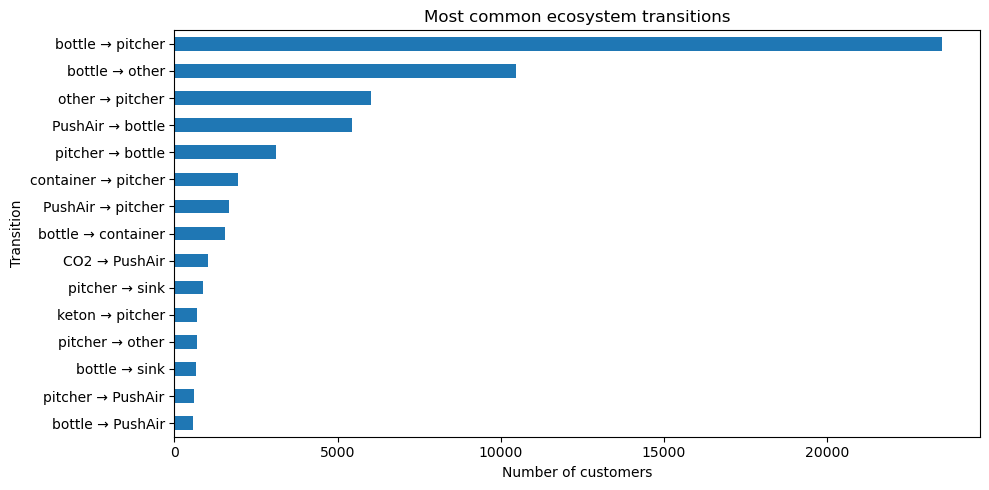

In [6]:
import matplotlib.pyplot as plt

top_n = 15

transition_counts = (
    transitions["transition"]
    .value_counts()
    .head(top_n)
)

plt.figure(figsize=(10, 5))
transition_counts.sort_values().plot(kind="barh")

plt.title("Most common ecosystem transitions")
plt.xlabel("Number of customers")
plt.ylabel("Transition")

plt.tight_layout()
plt.show()


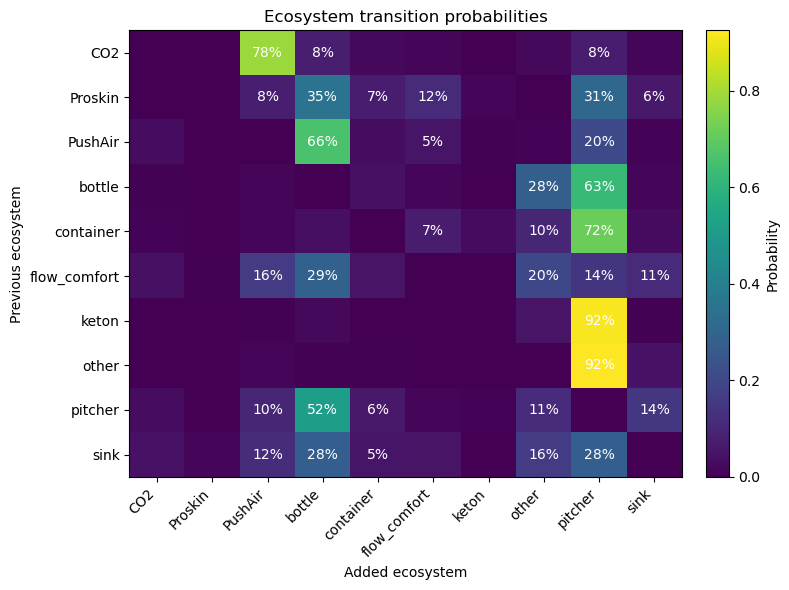

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Transition matrix
tm = (
    transitions
    .groupby(["prev_ecosystem", "ecosystem"])
    .size()
    .unstack(fill_value=0)
)

# Row-normalise (probabilities)
tm_prob = tm.div(tm.sum(axis=1), axis=0)

plt.figure(figsize=(8, 6))
im = plt.imshow(tm_prob, aspect="auto")

plt.colorbar(im, fraction=0.046, pad=0.04, label="Probability")

plt.xticks(range(len(tm_prob.columns)), tm_prob.columns, rotation=45, ha="right")
plt.yticks(range(len(tm_prob.index)), tm_prob.index)

plt.title("Ecosystem transition probabilities")
plt.xlabel("Added ecosystem")
plt.ylabel("Previous ecosystem")

# Annotate meaningful cells
for i in range(tm_prob.shape[0]):
    for j in range(tm_prob.shape[1]):
        val = tm_prob.iloc[i, j]
        if val > 0.05:
            plt.text(j, i, f"{val:.0%}", ha="center", va="center", color="white")

plt.tight_layout()
plt.show()


## 7. Order-level ecosystem sets (MULTI-aware representation)

Customers can purchase items from multiple ecosystems in a single order.  
To correctly detect ecosystem expansion, we first convert line-level purchases into an **order-level ecosystem set**.

**Unit of aggregation**
- One row per `anon × purchase_k` (purchase days only).

**What we build**
- `ecos`: a deterministic tuple representation of the unique ecosystems present in the order  
  (constructed as `tuple(sorted(set(ecosystems)))` so results are stable and comparable).
- `n_ecos`: number of unique ecosystems in the order.
- `order_state`: a simple label used for inspection:
  - if `n_ecos == 1`, we store the single ecosystem name (e.g., `"bottle"`)
  - otherwise `"MULTI"` (meaning the order spans multiple ecosystems)

**Why this matters**
- This step is the foundation for the canonical transition logic:
  true ecosystem additions are computed using **set difference** between consecutive orders:
  \[
  \text{added\_ecosystems}_k = \text{ecosystems}_k \setminus \text{ecosystems}_{k-1}
  \]
- MULTI orders are handled naturally because we work with sets rather than forcing a single ecosystem per order.

**Note**
- `"UNMAPPED"` rows are excluded here to avoid mapping gaps creating artificial ecosystems.


In [8]:
# df_p has: anon, purchase_k, ecosystem, date (and purchase lines)
order_ecos = (
    df_p[df_p["ecosystem"] != "UNMAPPED"]
    .groupby(["anon", "purchase_k"], as_index=False)
    .agg(
        date=("date", "min"),
        ecos=("ecosystem", lambda s: tuple(sorted(set(s))))
    )
)

order_ecos["n_ecos"] = order_ecos["ecos"].apply(len)

# label order type
order_ecos["order_state"] = np.where(
    order_ecos["n_ecos"] == 1,
    order_ecos["ecos"].apply(lambda t: t[0]),
    "MULTI"
)

display(order_ecos.head(4))


,anon,purchase_k,date,ecos,n_ecos,order_state
0,ANON_0000001,1,2022-09-11,"(bottle,)",1,bottle
1,ANON_0000002,1,2022-09-11,"(bottle,)",1,bottle
2,ANON_0000003,1,2022-09-11,"(sink,)",1,sink
3,ANON_0000004,1,2022-09-11,"(bottle,)",1,bottle


## 9. Canonical ecosystem addition logic (MULTI-aware)

This is the **source-of-truth** lifecycle definition used in the analysis.

### Step 1 — Order-level ecosystem sets
We aggregate purchase lines into an order-level representation:
- one row per `anon × purchase_k`
- `ecos`: the set of unique ecosystems present in the order  
  (MULTI orders are represented naturally)

### Step 2 — True ecosystem additions via set difference
For each customer, we compare consecutive orders using set logic:
\[
\text{new\_ecos}_k = \text{ecos}_k \setminus \text{ecos}_{k-1}
\]
An order is flagged as an ecosystem expansion event if:
- `has_new_ecosystem = (len(new_ecos) > 0)`

This definition works for both single-ecosystem and MULTI-ecosystem baskets without forcing an artificial ordering.


In [34]:
# Build ecosystem set per order (MULTI-aware)
order_ecos = (
    df_p[df_p["ecosystem"] != "UNMAPPED"]
    .groupby(["anon", "purchase_k"], as_index=False)
    .agg(
        date=("date", "min"),
        ecos=("ecosystem", lambda s: tuple(sorted(set(s)))),
    )
).sort_values(["anon", "purchase_k"])


In [35]:
# Previous order ecosystem set
order_ecos["prev_ecos"] = order_ecos.groupby("anon")["ecos"].shift(1)

# Only orders where a previous order exists
valid = order_ecos.dropna(subset=["prev_ecos"]).copy()

# New ecosystems added in this order (set difference)
valid["new_ecos"] = valid.apply(
    lambda r: set(r["ecos"]) - set(r["prev_ecos"]),
    axis=1
)

# Flag if ANY new ecosystem appeared
valid["has_new_ecosystem"] = valid["new_ecos"].map(len) > 0

total_orders_with_prev = len(valid)
orders_with_new_eco = valid["has_new_ecosystem"].sum()

print(f"Orders with a previous order: {total_orders_with_prev:,}")
print(f"Orders where a NEW ecosystem was added: {orders_with_new_eco:,}")
print(f"Share: {orders_with_new_eco / total_orders_with_prev:.2%}")


Orders with a previous order: 76,360
Orders where a NEW ecosystem was added: 17,255
Share: 22.60%


## 10. Canonical ecosystem addition events (MULTI-aware, source of truth)

This section defines the **final and authoritative lifecycle logic** used in the analysis.

We identify **true ecosystem additions** by comparing consecutive orders at the **order level**, using set operations that naturally support MULTI-ecosystem baskets.

---

### Step 1 — Previous order ecosystem context

For each customer (`anon`), orders are sorted by `purchase_k`.  
We attach the ecosystem set from the previous order:

- `ecos`      — ecosystems present in the current order  
- `prev_ecos` — ecosystems present in the previous order

Only orders with a valid previous order are considered for lifecycle events.

---

### Step 2 — Set-based lifecycle decomposition

For each eligible order, we decompose the ecosystem change using set algebra:

- **Added ecosystems**  
  \[
  \text{added\_ecos} = \text{ecos} \setminus \text{prev\_ecos}
  \]

- **Dropped ecosystems**  
  \[
  \text{dropped\_ecos} = \text{prev\_ecos} \setminus \text{ecos}
  \]

- **Kept ecosystems**  
  \[
  \text{kept\_ecos} = \text{ecos} \cap \text{prev\_ecos}
  \]

This decomposition works consistently for:
- single-ecosystem orders
- MULTI-ecosystem orders
- multiple ecosystem additions in a single purchase

No artificial ordering or assumptions are introduced.

---

### Step 3 — One row per true addition event

We then:
- keep only orders where at least one ecosystem was added,
- **explode `added_ecos`** so that each row represents exactly **one ecosystem addition event**.

Each row in the resulting table corresponds to:
> “Customer *anon* added ecosystem *X* at purchase *k*, given their previous and current ecosystem context.”

---

### Output: `events` (canonical table)

Each row contains:
- `anon` — customer identifier  
- `purchase_k` — order index where the addition occurred  
- `date` — order date  
- `added_ecosystem` — ecosystem that was newly introduced  
- `prev_ecos_str` — ecosystems present before the order  
- `curr_ecos_str` — ecosystems present after the order  
- `kept_ecos_str` — ecosystems retained across orders  
- `dropped_ecos_str` — ecosystems no longer present  

This table is the **single source of truth** for:
- ecosystem expansion analysis,
- gateway product identification,
- downstream LTV and pathway modelling.

All earlier transition or first-occurrence views are strictly descriptive and are not used for lifecycle inference.


In [36]:
# order_ecos already built earlier (anon, purchase_k, date, ecos as tuple)
order_ecos = order_ecos.sort_values(["anon", "purchase_k"]).copy()
order_ecos["prev_ecos"] = order_ecos.groupby("anon")["ecos"].shift(1)

# only orders where a previous order exists (customers with ≥2 orders)
valid = order_ecos.dropna(subset=["prev_ecos"]).copy()

# convert tuple -> set only for set algebra
valid["ecos_set"] = valid["ecos"].apply(set)
valid["prev_ecos_set"] = valid["prev_ecos"].apply(set)
valid["order_ecos"] = valid["ecos"].apply(set)  # or directly from order_ecos


# IMPORTANT: cumulative ownership (do not drop ecosystems)
valid["curr_state"] = valid.apply(
    lambda r: r["prev_ecos_set"] | r["ecos_set"],
    axis=1
)

# ecosystems added at this order (relative to previous owned state)
valid["added_ecos"] = valid.apply(
    lambda r: r["curr_state"] - r["prev_ecos_set"],
    axis=1
)

# flag whether any expansion happened
valid["has_expansion"] = valid["added_ecos"].apply(len) > 0

# explode BUT keep non-expanders (they will get NaN in added_ecosystem)
events = valid.explode("added_ecos").rename(
    columns={"added_ecos": "added_ecosystem"}
)

# make states readable (optional but useful)
events["prev_ecos_str"] = events["prev_ecos_set"].apply(
    lambda s: ", ".join(sorted(s))
)
events["curr_ecos_str"] = events["curr_state"].apply(
    lambda s: ", ".join(sorted(s))
)

events = events[
    [
        "anon",
        "purchase_k",
        "date",
        "order_ecos",          # <-- NEW, CRITICAL
        "added_ecosystem",
        "has_expansion",
        "prev_ecos_str",
        "curr_ecos_str",
    ]
].sort_values(["purchase_k", "anon"])

display(events.head(20))

print("Total eligible orders (k >= 2):", len(valid))
print("Orders with expansion:", valid["has_expansion"].sum())
print("Orders without expansion:", (~valid["has_expansion"]).sum())
print(
    "Share without expansion:",
    (~valid["has_expansion"]).mean()
)


,anon,purchase_k,date,order_ecos,added_ecosystem,has_expansion,prev_ecos_str,curr_ecos_str
9,ANON_0000009,2,2025-11-19,{bottle},bottle,True,pitcher,"bottle, pitcher"
12,ANON_0000011,2,2024-02-19,"{other, pitcher}",other,True,pitcher,"other, pitcher"
14,ANON_0000012,2,2024-09-26,"{pitcher, bottle}",bottle,True,pitcher,"bottle, pitcher"
22,ANON_0000019,2,2023-06-20,{bottle},NaN,False,bottle,bottle
32,ANON_0000027,2,2023-04-06,{pitcher},pitcher,True,bottle,"bottle, pitcher"
36,ANON_0000029,2,2025-02-08,"{pitcher, bottle}",NaN,False,"bottle, pitcher","bottle, pitcher"
41,ANON_0000033,2,2025-02-09,{bottle},NaN,False,bottle,bottle
46,ANON_0000037,2,2023-04-19,{bottle},NaN,False,bottle,bottle
50,ANON_0000040,2,2023-06-25,{bottle},NaN,False,bottle,bottle
54,ANON_0000043,2,2023-07-03,{pitcher},NaN,False,"bottle, pitcher","bottle, pitcher"


Total eligible orders (k >= 2): 76360
Orders with expansion: 17255
Orders without expansion: 59105
Share without expansion: 0.7740309062336301


In [37]:
n_customers_total = df_p["anon"].nunique()
n_customers_2plus = (
    df_p.groupby("anon")["purchase_k"].nunique().ge(2).sum()
)

print(f"Total customers: {n_customers_total:,}")
print(f"Customers with ≥2 orders: {n_customers_2plus:,}")
print(f"Share eligible for additions: {n_customers_2plus / n_customers_total:.2%}")


Total customers: 333,901
Customers with ≥2 orders: 52,157
Share eligible for additions: 15.62%


In [40]:
ANON = "ANON_0000009"   # <-- put customer id here

SHOW_COLS = [
    "anon",
    "date",
    "purchase_k",
    "MATRIX GRUPA PRODUKTOWA",
    "MATRIX NAZWA",
    "ecosystem",
]

# add optional columns if they exist
for c in ["last_matrix_name", "sku", "qty", "quantity", "item_name"]:
    if c in df_p.columns and c not in SHOW_COLS:
        SHOW_COLS.append(c)

cust_orders = (
    df_p[df_p["anon"] == ANON]
    .sort_values(["purchase_k", "MATRIX GRUPA PRODUKTOWA"])
)

print(f"Customer: {ANON}")
print(f"Total purchase lines: {len(cust_orders)}")
print(f"Total orders: {cust_orders['purchase_k'].nunique()}")

display(cust_orders[SHOW_COLS])


Customer: ANON_0000009
Total purchase lines: 3
Total orders: 2


,anon,date,purchase_k,MATRIX GRUPA PRODUKTOWA,MATRIX NAZWA,ecosystem
12,ANON_0000009,2022-10-11,1,10_dzbanki filtrujące Crystal,CRYSTAL 2L LED CLASSIC 1F,pitcher
13,ANON_0000009,2025-11-19,2,03_butelki filtrujące SOLID,"SOLID 0,7 1F",bottle
14,ANON_0000009,2025-11-19,2,06_filtry do butelek Soft i Solid,1 FILTR BUTELKOWY,bottle


In [39]:
# -------------------------
# Save canonical artifacts
# -------------------------

OUT_DIR = Path("../data/interim")
OUT_DIR.mkdir(parents=True, exist_ok=True)

events_path = OUT_DIR / "ecosystem_add_events.parquet"
order_ecos_path = OUT_DIR / "order_ecosystem_sets.parquet"

events.to_parquet(events_path, index=False)
order_ecos.to_parquet(order_ecos_path, index=False)

print(f"Saved ecosystem addition events to: {events_path}")
print(f"Saved order-level ecosystem sets to: {order_ecos_path}")


Saved ecosystem addition events to: ../data/interim/ecosystem_add_events.parquet
Saved order-level ecosystem sets to: ../data/interim/order_ecosystem_sets.parquet
